# CNN models

Iterating on convolutional neural networks

In [14]:
import os
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras import models
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten

from functions import *

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load images for modeling

Use `ImageDataGenerator` class from Keras with `flow_from_directory` method to feed images into the model.

In [2]:
# Image folder for training
train_dir = 'input_images/train'

In [3]:
# Delete metadata files created by Mac OS
!find . -name ".DS_Store" -delete

In [4]:
# Get data from directories and scale
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.1)

train_gen = datagen.flow_from_directory(train_dir, subset='training', class_mode='binary')
val_gen = datagen.flow_from_directory(train_dir, subset='validation', class_mode='binary', shuffle=False)

Found 1226 images belonging to 2 classes.
Found 135 images belonging to 2 classes.


## CNN1 (first try!)

Trying without image augmentation first, just 15 epochs to start.

In [5]:
# Instatiate model
cnn_model_1 = models.Sequential()

# Add model layers - Using architecture from Canvas 'CNN from Scratch - Lab' to start
cnn_model_1.add(Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)))
cnn_model_1.add(MaxPooling2D((2, 2)))
cnn_model_1.add(Conv2D(64, (3, 3), activation='relu'))
cnn_model_1.add(MaxPooling2D((2, 2)))
cnn_model_1.add(Conv2D(128, (3, 3), activation='relu'))
cnn_model_1.add(MaxPooling2D((2, 2)))
cnn_model_1.add(Conv2D(128, (3, 3), activation='relu'))
cnn_model_1.add(MaxPooling2D((2, 2)))
# Flatten
cnn_model_1.add(Flatten())
# Final Dense layers
cnn_model_1.add(Dense(512, activation='relu'))
cnn_model_1.add(Dense(1, activation='sigmoid'))

# Compile
cnn_model_1.compile(optimizer='adam',
                    loss='binary_crossentropy',
                    metrics=['acc', 'Recall', 'Precision'])

In [6]:
# Train the model
cnn_history_1 = cnn_model_1.fit(train_gen,
                                epochs=15, 
                                validation_data=val_gen)

Epoch 1/15
39/39 [==============================] - 209s 5s/step - loss: 0.6174 - acc: 0.6852 - recall: 0.7767 - precision: 0.6593 - val_loss: 0.3543 - val_acc: 0.8889 - val_recall: 0.9265 - val_precision: 0.8630
Epoch 2/15
39/39 [==============================] - 186s 5s/step - loss: 0.3626 - acc: 0.8442 - recall: 0.8107 - precision: 0.8713 - val_loss: 0.4390 - val_acc: 0.8444 - val_recall: 0.9853 - val_precision: 0.7701
Epoch 3/15
39/39 [==============================] - 165s 4s/step - loss: 0.3086 - acc: 0.8630 - recall: 0.8301 - precision: 0.8906 - val_loss: 0.2229 - val_acc: 0.9037 - val_recall: 0.9412 - val_precision: 0.8767
Epoch 4/15
39/39 [==============================] - 161s 4s/step - loss: 0.2698 - acc: 0.8834 - recall: 0.8867 - precision: 0.8824 - val_loss: 0.3096 - val_acc: 0.8963 - val_recall: 1.0000 - val_precision: 0.8293
Epoch 5/15
39/39 [==============================] - 161s 4s/step - loss: 0.2244 - acc: 0.9119 - recall: 0.9110 - precision: 0.9140 - val_loss: 0.183

In [7]:
cnn_model_1.save('models/cnn_model_1.h5')

Training eval:
39/39 [==============================] - 134s 3s/step - loss: 0.0038 - acc: 1.0000 - recall: 1.0000 - precision: 1.0000

Validation eval:
5/5 [==============================] - 7s 1s/step - loss: 0.5721 - acc: 0.9407 - recall: 0.9706 - precision: 0.9167


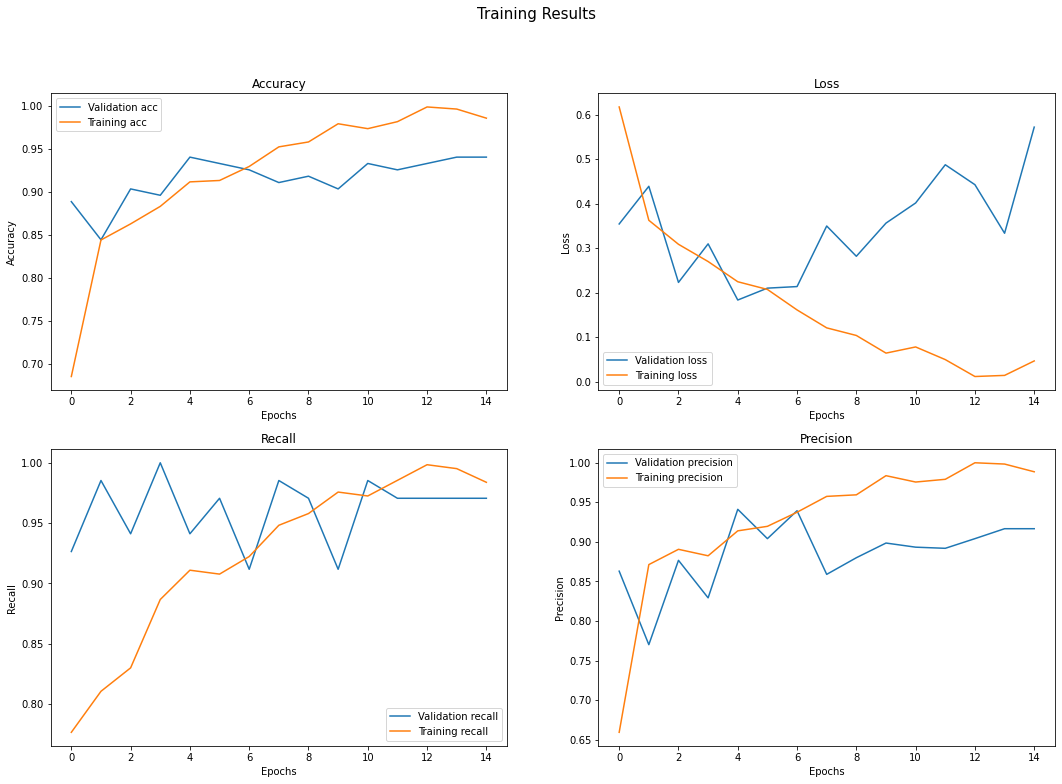

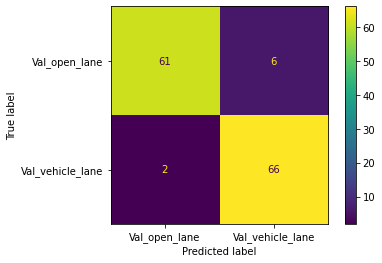

In [8]:
visualize_results(cnn_history_1, cnn_model_1, train_gen, val_gen)

In [9]:
dump(cnn_history_1.history, open('models/cnn_history_1.pkl', 'wb'))

Kind of amazing for a first try--CNNs are really amazing. But this is *way* overfit for sure. All the training metrics are at 100%! Insane.

Next steps:
 - regularization via L2 regularizers and/or dropout layers
 - image augmentation (with the NN it confused it and made it struggle to detect patterns; here it might help with overfitting and increase the training dataset)
 - Try batch normalization?

### Visualizing layers using feature maps

https://www.kaggle.com/arpitjain007/guide-to-visualize-filters-and-feature-maps-in-cnn

In [10]:
for layer in cnn_model_1.layers:
    if 'conv' not in layer.name:
        continue
    filters, bias = layer.get_weights()
    print(layer.name, filters.shape)

conv2d (3, 3, 3, 32)
conv2d_1 (3, 3, 32, 64)
conv2d_2 (3, 3, 64, 128)
conv2d_3 (3, 3, 128, 128)


In [11]:
filters, bias = cnn_model_1.layers[2].get_weights()

f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)

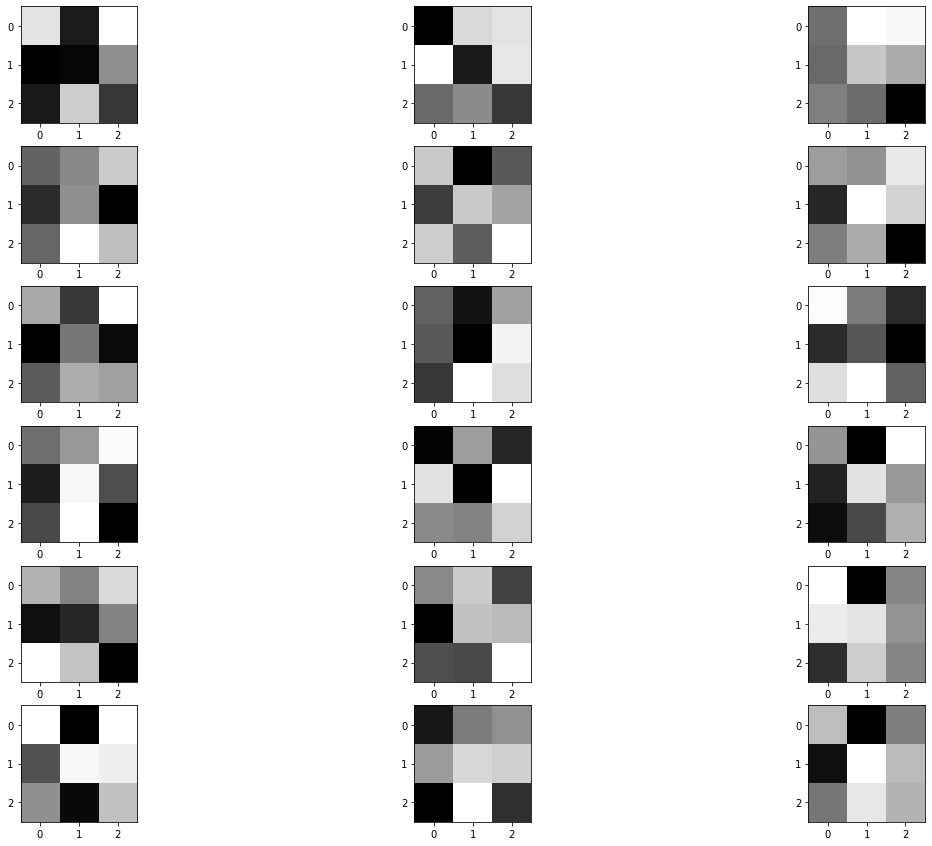

In [12]:
n_filters =6
ix=1
fig = plt.figure(figsize=(20,15))
for i in range(n_filters):
    # get the filters
    f = filters[:,:,:,i]
    for j in range(3):
        # subplot for 6 filters and 3 channels
        plt.subplot(n_filters,3,ix)
        plt.imshow(f[:,:,j] ,cmap='gray')
        ix+=1
#plot the filters 
plt.show()

In [13]:
model = keras.models.Model(cnn_model_1.inputs, cnn_model_1.layers[0].output)

In [62]:
images, labels = next(train_gen)
image = images[0]

In [63]:
image.shape

(256, 256, 3)

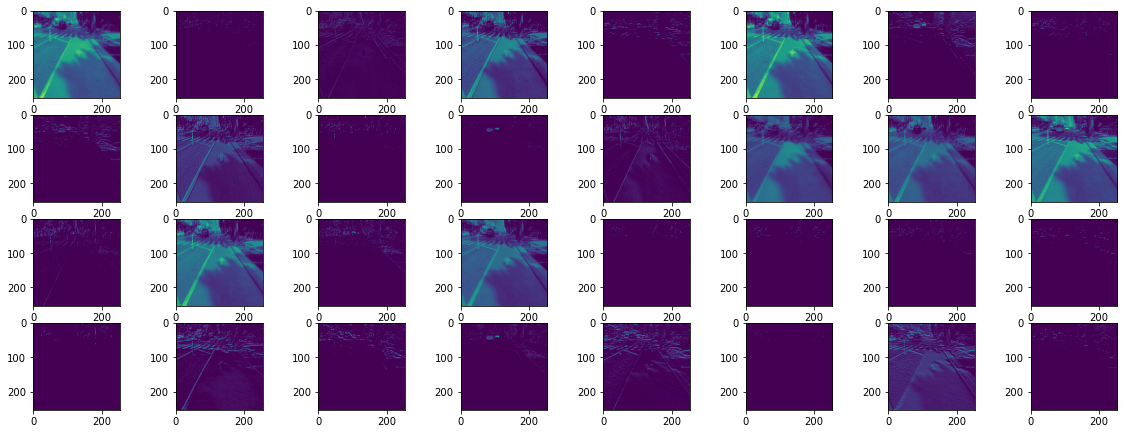

In [64]:
features = model.predict(image.reshape(1, 256, 256, 3))

fig = plt.figure(figsize=(20,15))
for i in range(1,features.shape[3]+1):

    plt.subplot(8,8,i)
    plt.imshow(features[0,:,:,i-1])
    
plt.show()

In [65]:
# Extract model layer outputs
layer_outputs = [layer.output for layer in cnn_model_1.layers[:8]]

# Rather then a model with a single output, we are going to make a model to display the feature maps
activation_model = models.Model(inputs=cnn_model_1.input, outputs=layer_outputs)

activations = activation_model.predict(image.reshape(1, 256, 256, 3))

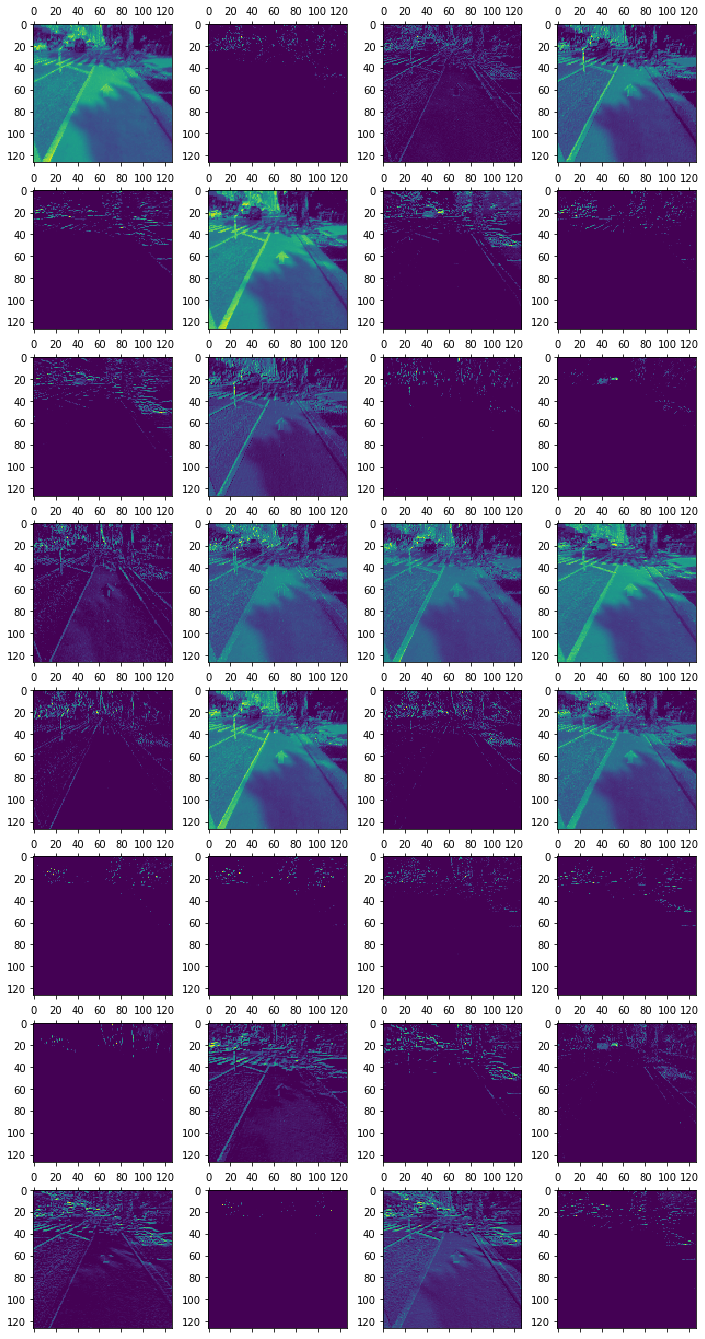

In [66]:
# Plot all filters from one activation layer
fig, axes = plt.subplots(8, 4, figsize=(12,24))
for i in range(32):
    row = i//4
    column = i%4
    ax = axes[row, column]
    first_layer_activation = activations[1]
    ax.matshow(first_layer_activation[0, :, :, i])

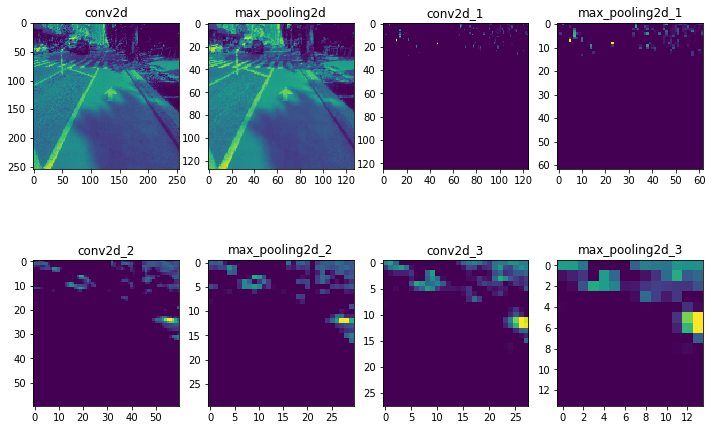

In [68]:
# Plot one filter from each activation layer
fig, axes = plt.subplots(2,4, figsize=(12,8))

layer_names = []
for layer in cnn_model_1.layers[:8]:
    layer_names.append(layer.name)

for i in range(8):
    row = i//4
    column = i%4
    ax = axes[row, column]
    cur_layer = activations[i]
    ax.matshow(cur_layer[0, :, :, 5])
    ax.xaxis.set_ticks_position('bottom')
    ax.set_title(layer_names[i])